In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch import optim
import gym
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [169]:
# sum rewards cumulatively, so earlier steps (i.e. steps that led to further steps)
# get more total reward
def cumsum_rewards(r,gamma):
    out=r.new_empty(len(r))
    csum=0.
    for i in reversed(range(len(r))):
        csum=gamma*csum+r[i]
        out[i]=csum
    return out

In [270]:
env=gym.make('CartPole-v1')

# replace original env.reset() to set-up more aggressive initial states
# (i.e. higher velocities, accelerations and more deviation from vertical)
from types import MethodType
orig_reset=env.env.reset
def reset(self):
    orig_reset()
    self.state=self.np_random.uniform(low=-1.,high=1.,size=(4,))
    return self.state

# do some hot-patching w/ env to get more visually pleasing simulations
def do_vismod():
    env.env.reset=MethodType(reset,env.env)

    env._max_episode_steps=2000 # allow for more episode steps than 500 originally

    # increase angle and distance limits, so pole falling is more visually
    # pronounced (taken from original code in CartPoleEnv.__init__())
    env.env.theta_threshold_radians=60*np.pi/180
    env.env.x_threshold=5.
    high=np.array([
        env.env.x_threshold*2,
        np.finfo(np.float32).max,
        env.env.theta_threshold_radians*2,
        np.finfo(np.float32).max
    ],dtype=np.float32)
    env.env.observation_space = gym.spaces.Box(-high, high, dtype=np.float32)

    # set higher force for action to increase correcting capability of our algo,
    # w/ harsher initial states this is (probably) fair
    env.env.force_mag=100.

last episode: 1068
36.79526615142822 s
tensor([27.1681, 24.2353, 22.5899, 28.4727, 30.4514, 31.2227, 29.5668, 27.4432,
        31.4333, 31.6868])
tensor(76.9522) [459.0, 407.0, 279.0, 517.0, 518.0, 554.0, 586.0, 711.0, 1076.0, 2000.0]


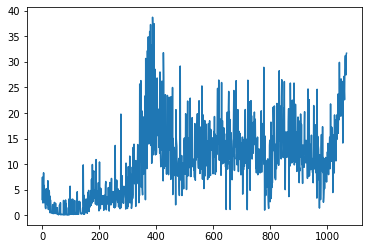

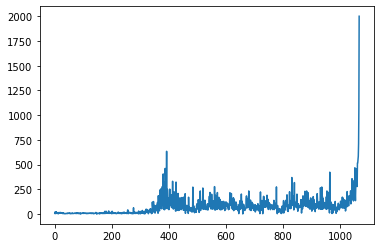

In [271]:
def dbg(**kws):
    if debug: [print(f'{k}:\n{v}') for k,v in kws.items()]

debug=0
vismod=1
n_ep=5000
n_hid=20
a_size=2 # action space size
gamma=.99
lr=.01
dev=torch.device('cpu')

if vismod: do_vismod()

# torch.manual_seed(1)
# env.seed(1)

m=nn.Sequential(
    nn.Linear(4,n_hid)
    ,nn.Sigmoid()
    ,nn.Linear(n_hid,a_size)
    ,nn.Softmax(dim=1)
).to(dev)
opt=optim.Adam(m.parameters(),lr=lr)

losses=[]
totrwds=[]
t0=time()
for ep in range(n_ep):
    s=env.reset()
    done=0
    states=[]
    actions=[]
    rewards=[]
    while not done:
        if ep%100==0: env.render()
        # don't do grads now, we'll accumulate all the states and do them later
        # vector-style in one fell swoop
        with torch.no_grad():
            a_probs=m(torch.tensor([s],dtype=torch.float,device=dev)).cpu()[0]
        a=int(torch.tensor(0.).uniform_()>a_probs[0]) # choose action probabilistically
        s1,r,done,_=env.step(a)
        states.append(s)
        actions.append(a)
        rewards.append(r)
        s=s1
    
    states=torch.tensor(states,dtype=torch.float,device=dev)
    outs=m(states)
    idxs=torch.arange(len(actions),device=dev)*a_size+torch.tensor(actions,device=dev)
    probs=outs.reshape(-1)[idxs]
    cumrwds=cumsum_rewards(torch.tensor(rewards,device=dev),gamma)
    loss=-(probs.log()*cumrwds).sum()/len(actions)
    dbg(states=states,outs=outs,acts=actions,probs=probs,rwds=cumrwds)
    dbg(loss=loss,steps=len(rewards))
    losses.append(loss)
    loss.backward()
    dbg(grads=[p.grad for p in m.parameters()])
    opt.step()
    opt.zero_grad()

    totrwds.append(sum(rewards))
    # if we managed to do max steps for episode, render one more episode
    # to visually confirm and finish
    if totrwds[-1]>=env._max_episode_steps:
        s=env.reset()
        done=0
        while not done:
            env.render()
            a=int(m(torch.tensor([s],dtype=torch.float,device=dev)).cpu()[0].argmax())
            s,_,done,_=env.step(a)
        print('last episode:',ep+1)
        break
    
print(time()-t0,'s')
env.close()
losses=torch.tensor(losses)
print(losses[-10:])
print(torch.tensor(totrwds).mean(),totrwds[-10:])
plt.plot(losses)
plt.show()
plt.plot(totrwds)

In [276]:
n=100
tot=0
limit=200
for _ in range(n):
    s=env.reset()
    done=0
    i=0
    while not done:
        i+=1
#         env.render()
        with torch.no_grad():
            a=int(m(torch.tensor([s],dtype=torch.float))[0].argmax())
        s1,r,done,_=env.step(a)
        tot+=r
        s=s1
        if limit and i>=limit: done=1
env.close()
avgrwd=tot/n
print(avgrwd)
if avgrwd>=195:
    print('task is SOLVED')
else:
    print('task is NOT solved')

198.26
task is SOLVED
